<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_private/blob/main/Simple_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How to Develop a 1D Generative Adversarial Network From Scratch in Keras**

Code from:
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

199 1.0 0.9900000095367432


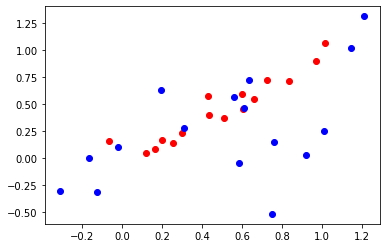

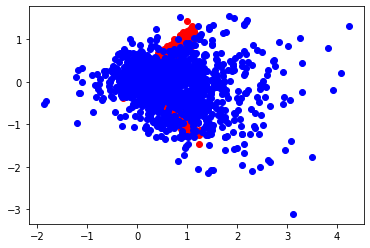

399 0.23999999463558197 0.8799999952316284


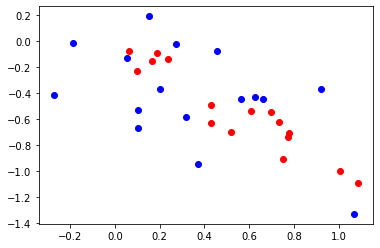

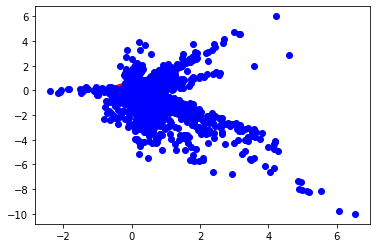

599 0.7699999809265137 0.7699999809265137


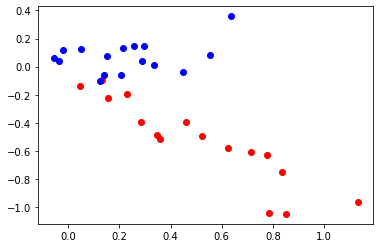

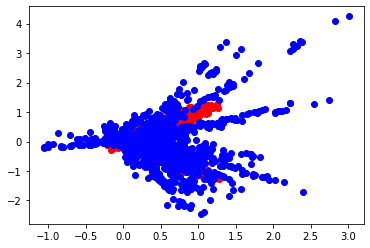

799 0.6200000047683716 0.5600000023841858


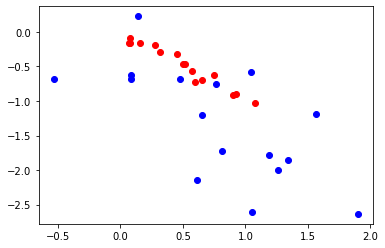

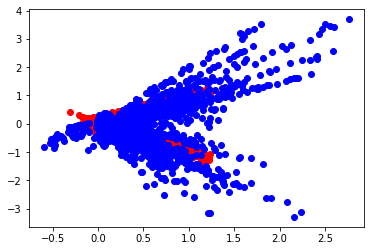

999 0.4699999988079071 0.3700000047683716


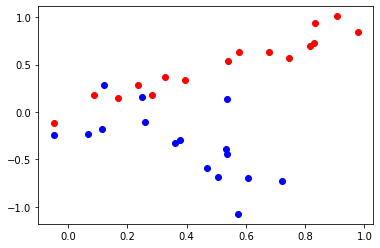

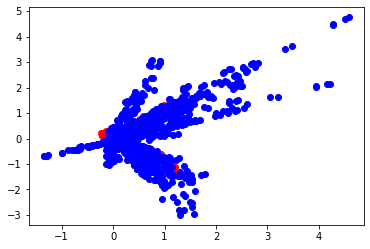

1199 0.550000011920929 0.6899999976158142


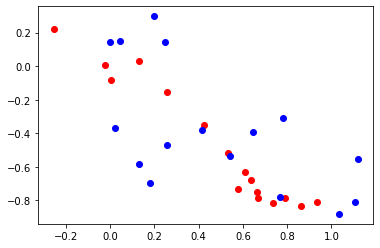

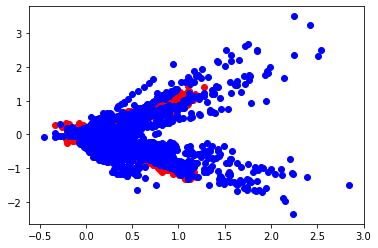

1399 0.550000011920929 0.6800000071525574


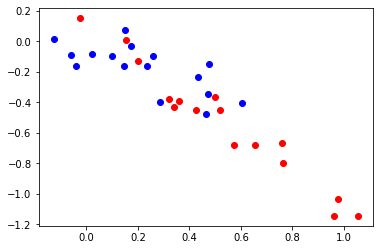

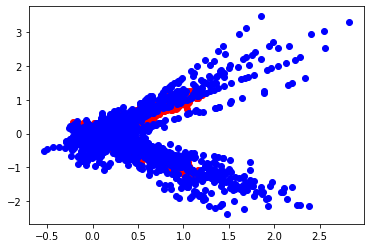

1599 0.3100000023841858 0.46000000834465027


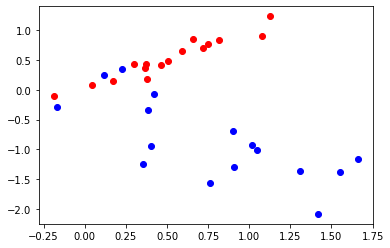

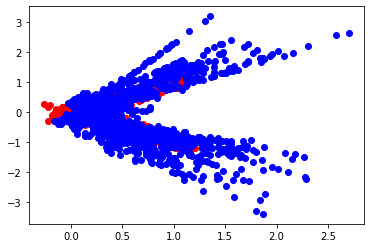

1799 0.6600000262260437 0.1599999964237213


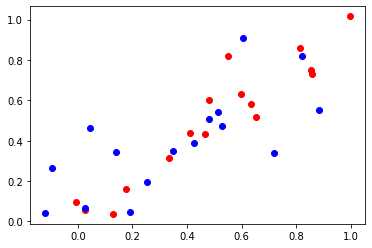

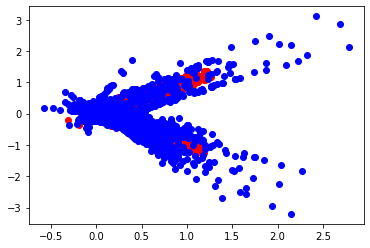

1999 0.3700000047683716 0.2199999988079071


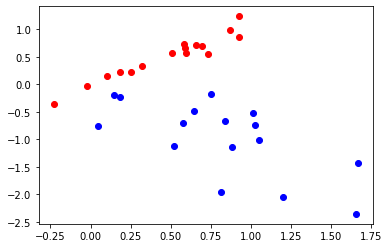

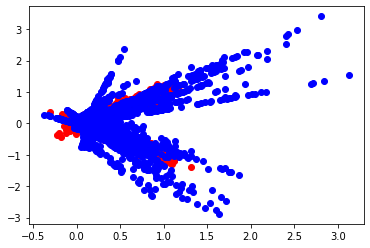

2199 0.6600000262260437 0.4099999964237213


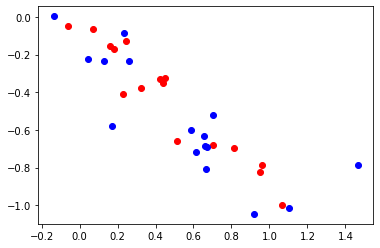

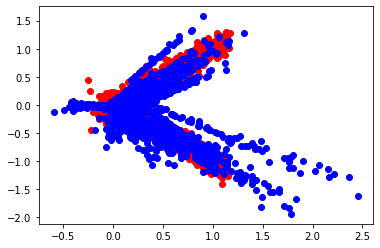

2399 0.23000000417232513 0.8600000143051147


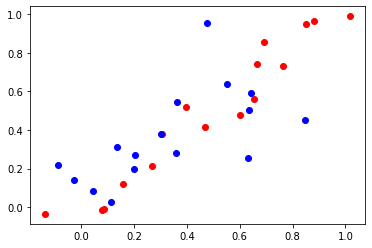

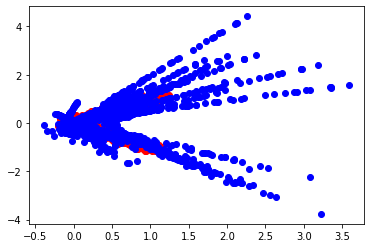

2599 0.8899999856948853 0.7599999904632568


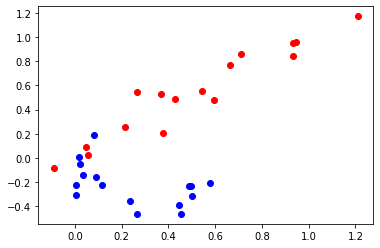

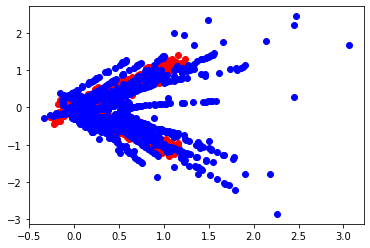

2799 0.7599999904632568 0.5299999713897705


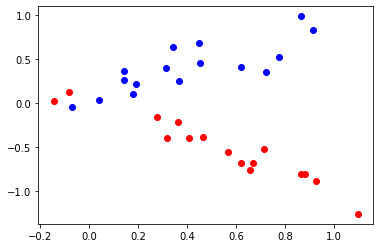

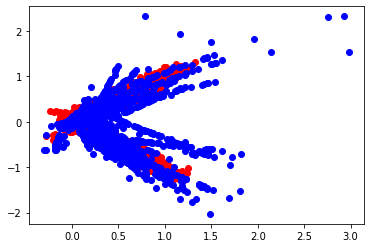

2999 0.5299999713897705 0.3700000047683716


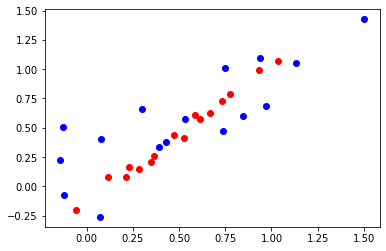

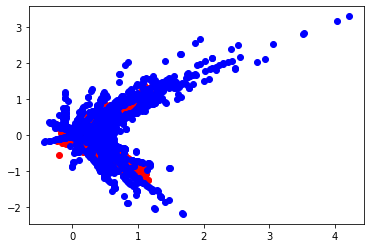

3199 0.6899999976158142 0.4000000059604645


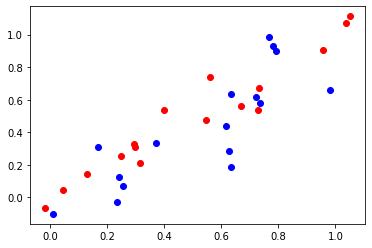

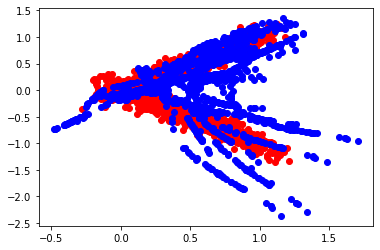

3399 0.7599999904632568 0.41999998688697815


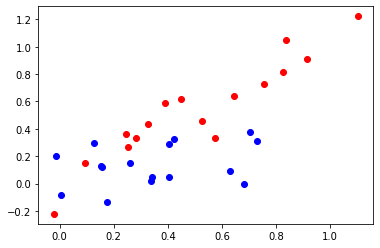

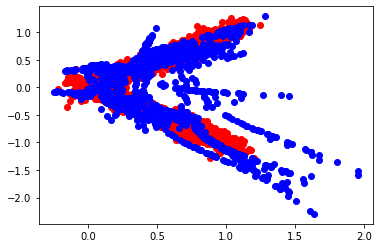

3599 0.6399999856948853 0.9300000071525574


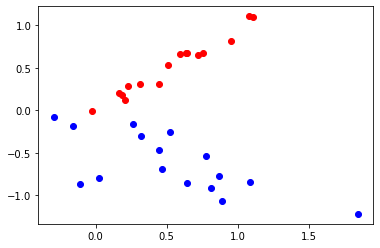

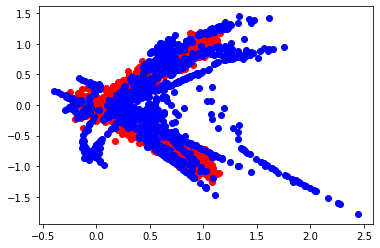

3799 0.6800000071525574 0.7599999904632568


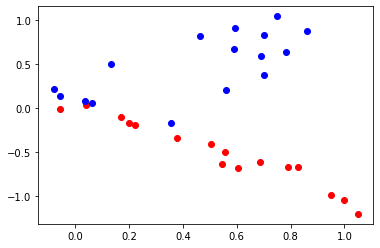

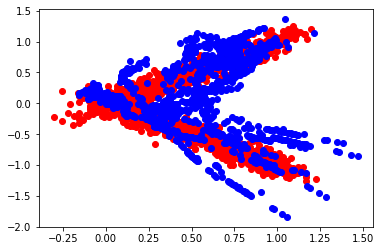

3999 0.7599999904632568 0.6800000071525574


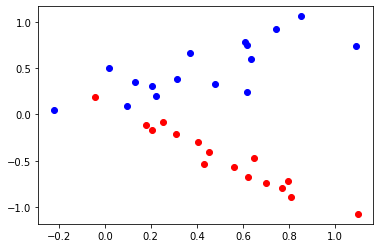

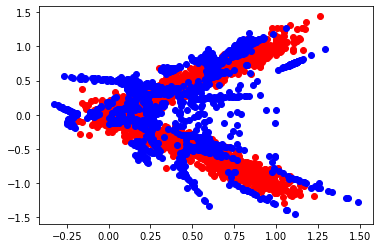

4199 0.550000011920929 0.6000000238418579


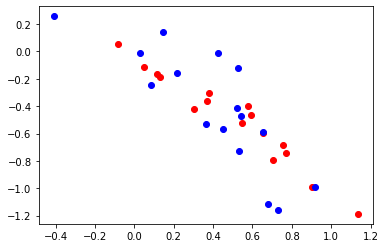

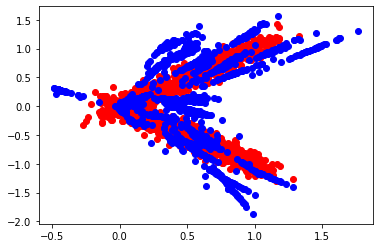

4399 0.5899999737739563 0.4000000059604645


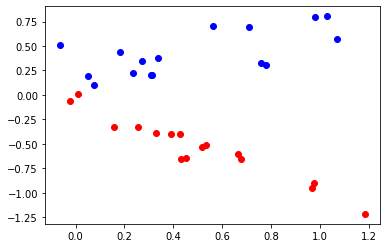

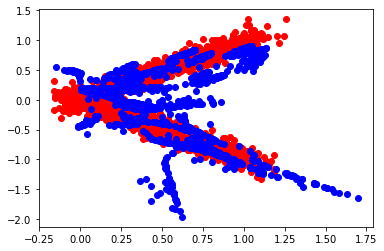

4599 0.8100000023841858 0.550000011920929


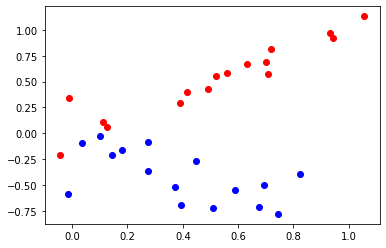

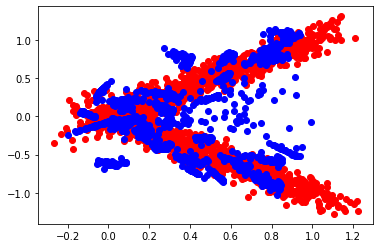

4799 0.75 0.5899999737739563


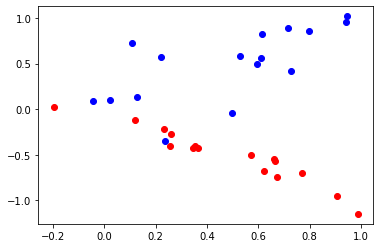

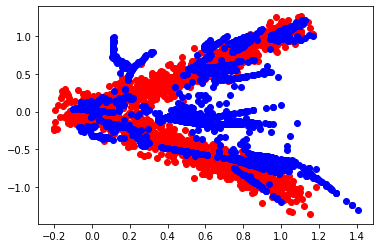

4999 0.6200000047683716 0.10999999940395355


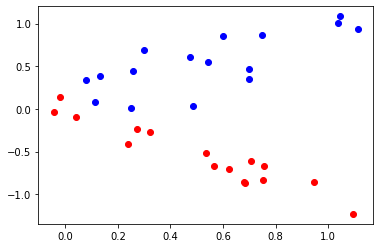

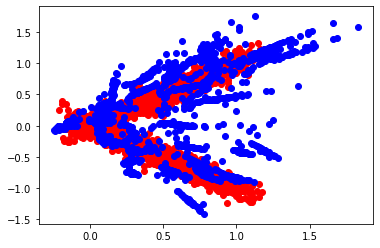

5199 0.3700000047683716 0.47999998927116394


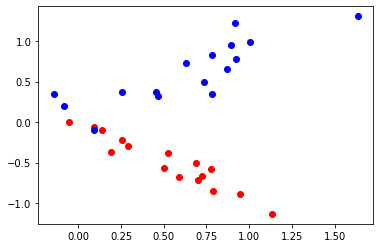

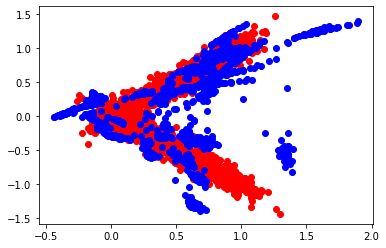

5399 0.6399999856948853 0.7799999713897705


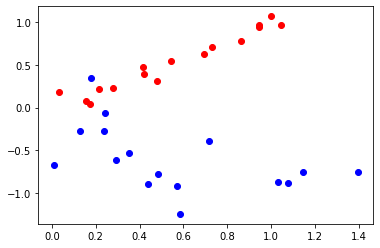

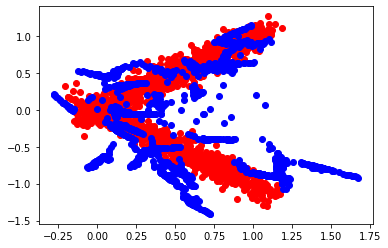

5599 0.6200000047683716 0.41999998688697815


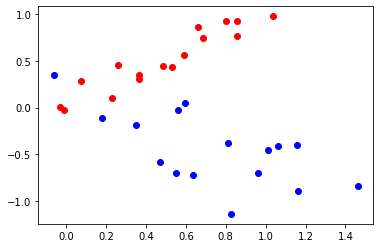

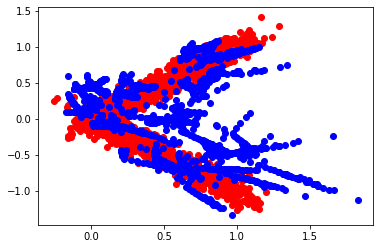

5799 0.46000000834465027 0.6299999952316284


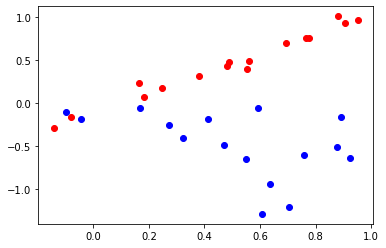

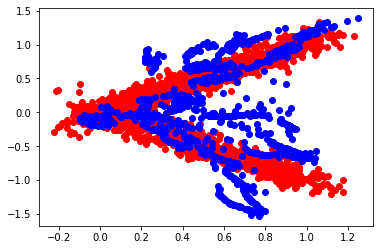

5999 0.7300000190734863 0.6800000071525574


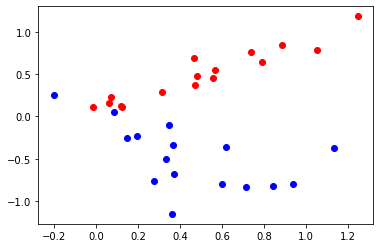

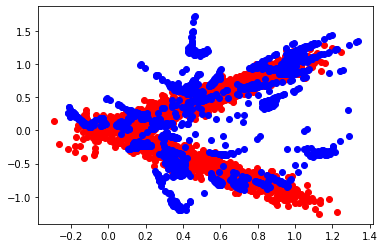

6199 0.5799999833106995 0.5


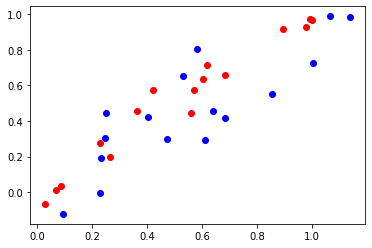

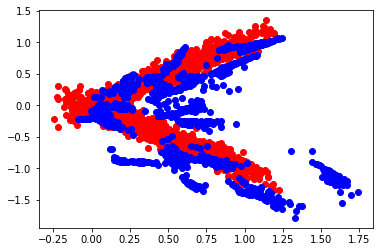

6399 0.7400000095367432 0.07000000029802322


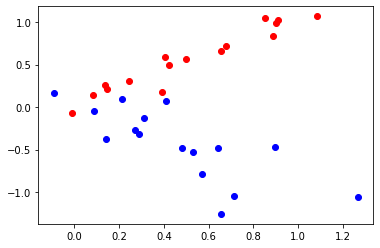

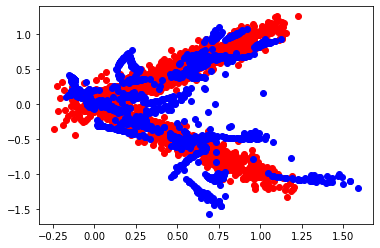

6599 0.8600000143051147 0.6200000047683716


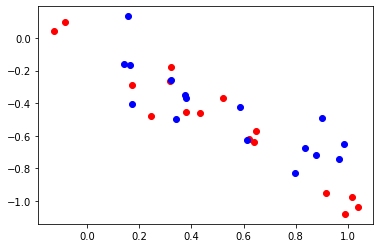

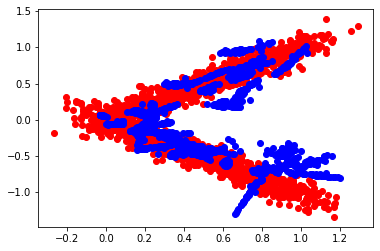

6799 0.5699999928474426 0.46000000834465027


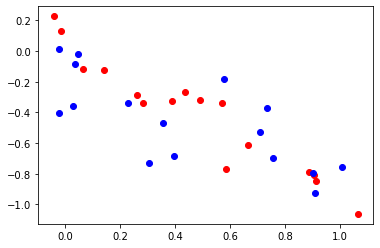

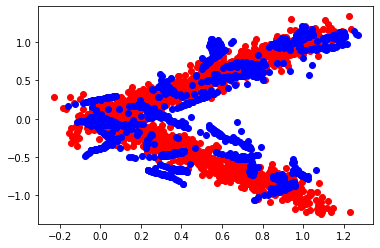

6999 0.5299999713897705 0.20999999344348907


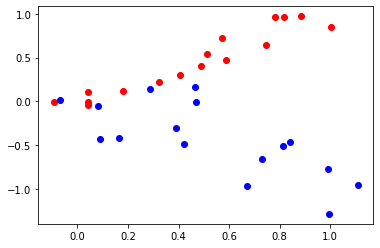

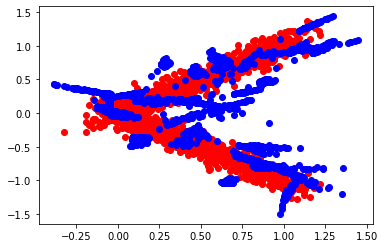

7199 0.6700000166893005 0.07000000029802322


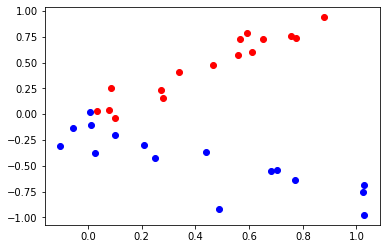

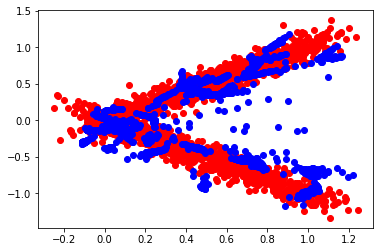

7399 0.18000000715255737 0.38999998569488525


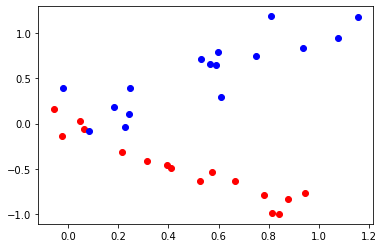

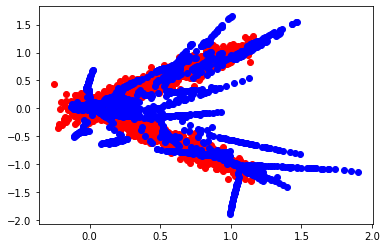

7599 0.44999998807907104 0.6000000238418579


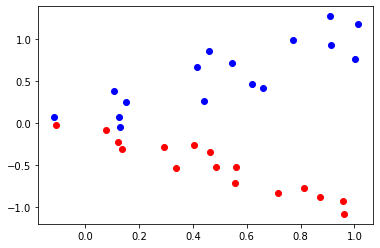

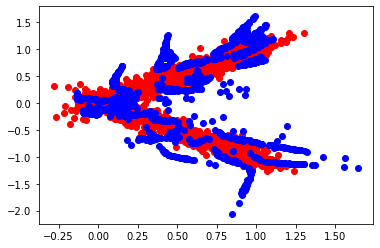

7799 0.33000001311302185 0.7699999809265137


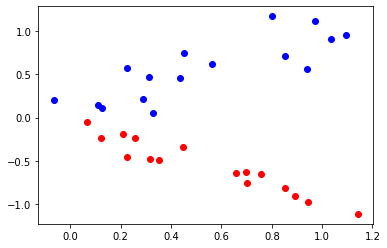

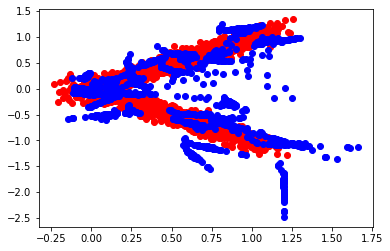

7999 0.5199999809265137 0.4699999988079071


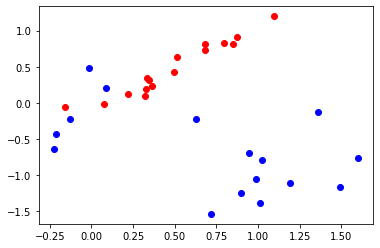

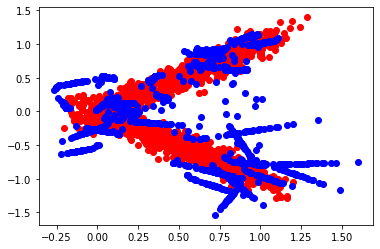

8199 0.7300000190734863 0.05999999865889549


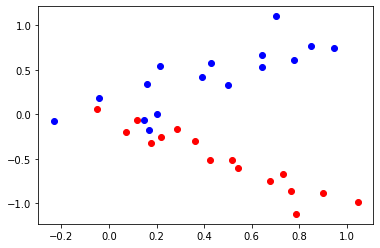

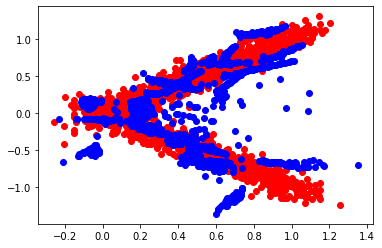

8399 0.8700000047683716 0.33000001311302185


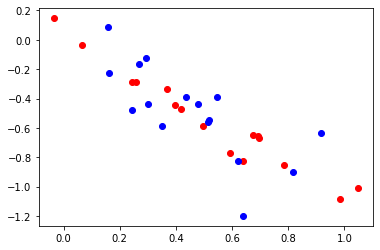

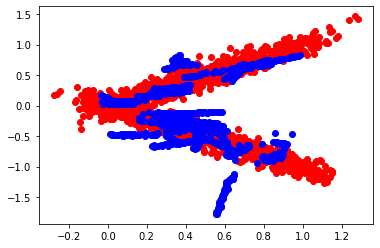

8599 0.5099999904632568 0.05000000074505806


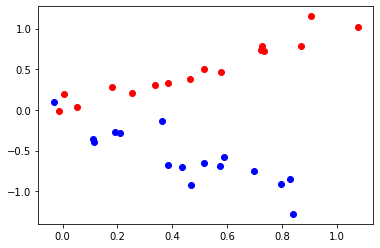

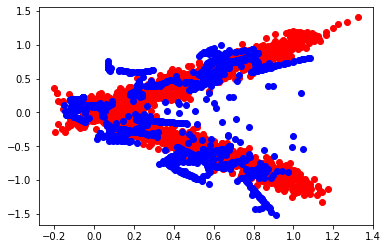

8799 0.6800000071525574 0.3199999928474426


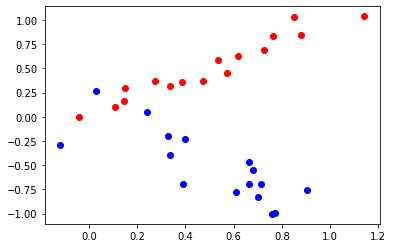

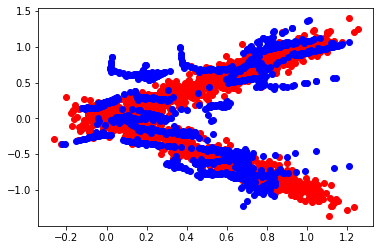

8999 0.2800000011920929 0.10999999940395355


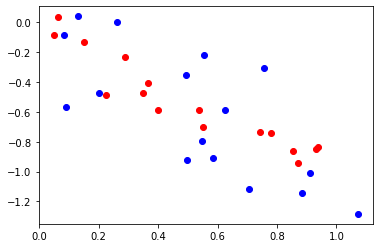

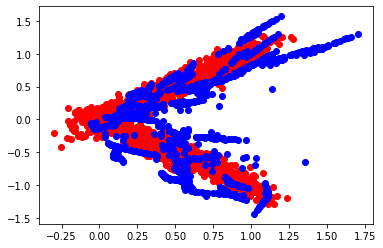

9199 0.25 0.4099999964237213


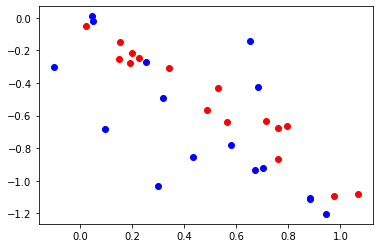

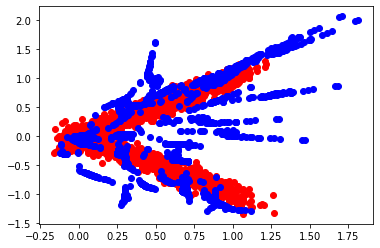

9399 0.3799999952316284 0.47999998927116394


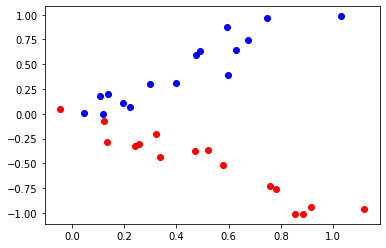

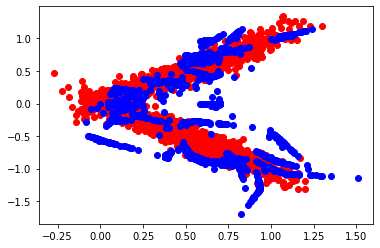

9599 0.5400000214576721 0.5699999928474426


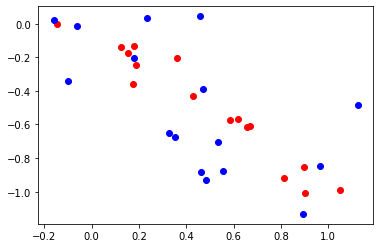

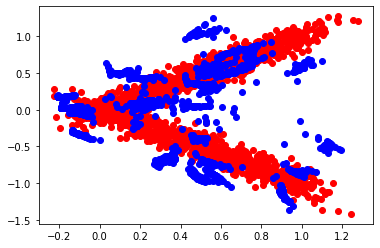

9799 0.23000000417232513 0.9900000095367432


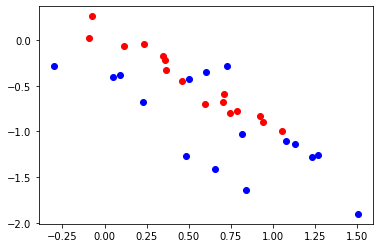

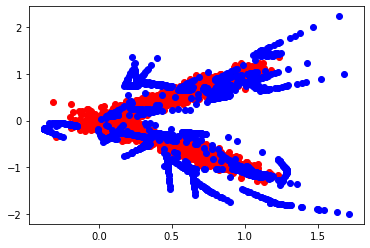

9999 0.47999998927116394 0.3700000047683716


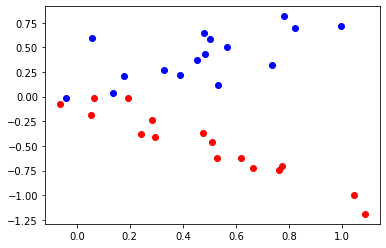

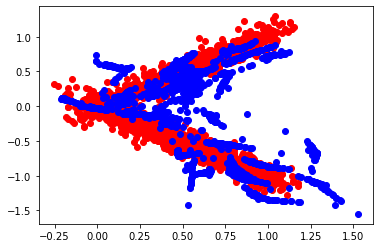

In [1]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense, Flatten
from matplotlib import pyplot

import numpy as np


In [ ]:

# length of the input vector
vec_length=16


define the standalone discriminator model

In [ ]:

# define the standalone discriminator model
def define_discriminator(n_inputs=2*vec_length):
  model = Sequential()
  model.add(Flatten(input_dim=n_inputs))
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform')) #25
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform'))
#  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


define the standalone generator model

In [ ]:

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2*vec_length):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim)) #15
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(n_outputs, activation='linear'))
	return model


define the combined generator and discriminator model, for updating the generator

In [ ]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model


generate n real samples with class labels

In [ ]:

# generate n real samples with class labels
def generate_real_samples(n):
  #print("generate ",n)

  X = np.zeros(shape=(n,2,vec_length))
  for i in range(0,n):
    x1 = np.linspace(0,1,vec_length) + 0.1*randn(vec_length)
    x2 = 2.*(np.random.randint(2, size=1)-0.5)*x1 + 0.1*randn(vec_length)
    X[i] = np.vstack((x1,x2))
    
  #print(X.shape)
  y = ones((n, 1))  
  return X, y

'''
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
  return X, y
'''



In [ ]:
generate points in latent space as input for the generator

In [ ]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input


use the generator to generate n fake examples, with class labels

In [ ]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input).reshape(n, 2, vec_length)
	# create class labels
	y = zeros((n, 1))
	return X, y


evaluate the discriminator and plot real and fake points

In [ ]:

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
  # prepare real samples
  x_real, y_real = generate_real_samples(n)
  # evaluate discriminator on real examples
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)

  # evaluate discriminator on fake examples
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
  pyplot.scatter(x_real[0, 0, ], x_real[0, 1, :], color='red')
  pyplot.scatter(x_fake[0, 0, :], x_fake[0,1, :], color='blue')
  pyplot.show()
  # scatter plot real and fake data points
  pyplot.scatter(x_real[:, 0, ], x_real[:, 1, :], color='red')
  pyplot.scatter(x_fake[:, 0, :], x_fake[:,1, :], color='blue')
  pyplot.show()


train the generator and discriminator

In [ ]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=200):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)


Run all

In [ ]:

# size of the latent space
latent_dim = 256
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)